In [ ]:
!pip install flask pyngrok --quiet

In [ ]:
#Install deps   (≈20 s)
!pip -q install --upgrade \
    tensorflow==2.18 keras==3.* \
    pandas requests requests_cache scikit-learn matplotlib pyngrok tqdm
import tensorflow as tf, os, platform, datetime, sys
print(f'✅  TensorFlow {tf.__version__} — GPU:', tf.config.list_physical_devices('GPU'))

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 89.9/89.9 kB 2.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 15.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.1/13.1 MB 32.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 61.4/61.4 kB 3.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 8.6/8.6 MB 56.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 66.5/66.5 kB 3.2 MB/s eta 0:00:00
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
google-colab 1.0.0 requires pandas==2.2.2, but you have pandas 2.2.3 which is incompatible.
✅  TensorFlow 2.18.0 — GPU: []


In [ ]:
#Imports / global config
from datetime import datetime, timedelta
import numpy as np, pandas as pd, requests_cache, requests, joblib, pickle, tqdm, os
#Site parameters
LAT, LON           = 49.847690, 24.024866           # Lviv
START_DATE, END_DATE = '2022-01-01', '2025-04-30'
HOURLY_VARS        = ['temperature_2m','cloudcover','windspeed_10m','shortwave_radiation']
#ML parameters
SEQ_LEN = 24
EPOCHS  = 50
BATCH   = 32
#Cache for HTTP
CACHE = requests_cache.CachedSession('meteocache', expire_after=86400)

In [ ]:
#Fetch weather archive (single API call, cached)
def fetch_archive(lat=LAT, lon=LON, start=START_DATE, end=END_DATE):
    url = (f"https://archive-api.open-meteo.com/v1/archive?latitude={lat}&longitude={lon}"
           f"&start_date={start}&end_date={end}&hourly={','.join(HOURLY_VARS)}&timezone=UTC")
    r = CACHE.get(url, timeout=60)
    r.raise_for_status()
    df = pd.DataFrame(r.json()['hourly'])
    df['datetime'] = pd.to_datetime(df.pop('time'))
    return df.set_index('datetime')
raw = fetch_archive()
print('Rows:', len(raw))
raw.head()

Rows: 29184


,temperature_2m,cloudcover,windspeed_10m,shortwave_radiation
datetime,,,,
2022-01-01 00:00:00,6.6,100,26.1,0.0
2022-01-01 01:00:00,6.6,100,27.6,0.0
2022-01-01 02:00:00,6.3,100,27.0,0.0
2022-01-01 03:00:00,6.3,100,27.8,0.0
2022-01-01 04:00:00,6.3,100,26.3,0.0


In [ ]:
#Pre‑processing & synthetic target
data = raw.rename(columns={'temperature_2m':'temp',
                           'cloudcover':'clouds',
                           'windspeed_10m':'wind_speed',
                           'shortwave_radiation':'radiation'})
data['clouds'] /= 100.0
np.random.seed(0)
data['pv_kw_actual'] = data['radiation']/10 + np.random.normal(0, 10, len(data))
data = data.interpolate(limit_direction='both').dropna()

In [ ]:
FEATS = ['temp', 'clouds', 'wind_speed', 'radiation']   # <-- замість HOURLY_VARS

#Train-test split, scaling, sequence builder  (оновлена версія)
from sklearn.preprocessing import MinMaxScaler

train_size = int(len(data) * 0.8)
train, test = data.iloc[:train_size], data.iloc[train_size:]

feat_scaler   = MinMaxScaler().fit(train[FEATS])
target_scaler = MinMaxScaler().fit(train[['pv_kw_actual']])

def to_seq(df):
    X, y = [], []
    arr = feat_scaler.transform(df[FEATS])
    tgt = target_scaler.transform(df[['pv_kw_actual']])
    for i in range(len(df) - SEQ_LEN):
        X.append(arr[i : i + SEQ_LEN])
        y.append(tgt[i + SEQ_LEN])
    return np.array(X), np.array(y)

Xtr, ytr = to_seq(train)
Xte, yte = to_seq(test)
print("Train:", Xtr.shape, ytr.shape, "  Test:", Xte.shape, yte.shape)


Train: (23323, 24, 4) (23323, 1)   Test: (5813, 24, 4) (5813, 1)


In [ ]:
#Define Conv1D→LSTM + Attention model
from keras import layers, models
def attention_block(inputs):
    score = layers.Dense(1, activation='tanh')(inputs)
    score = layers.Flatten()(score)
    score = layers.Activation('softmax')(score)
    score = layers.RepeatVector(inputs.shape[-1])(score)
    score = layers.Permute((2,1))(score)
    return layers.Multiply()([inputs, score])
inputs = layers.Input(shape=(SEQ_LEN, len(HOURLY_VARS)))
x = layers.Conv1D(64, 3, activation='relu', padding='same')(inputs)
x = layers.LSTM(64, return_sequences=True)(x)
x = attention_block(x)
x = layers.Flatten()(x)
x = layers.Dense(32, activation='relu')(x)
outputs = layers.Dense(1, activation='linear')(x)
model = models.Model(inputs, outputs)
model.compile(optimizer='adam', loss='mae')
model.summary()

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, 24, 4)     │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d (Conv1D)     │ (None, 24, 64)    │        832 │ input_layer[0][0] │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ lstm (LSTM)         │ (None, 24, 64)    │     33,024 │ conv1d[0][0]      │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense (Dense)       │ (None, 24, 1)     │         65 │ lstm[0][0]        │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ flatten (Flatten)   │ (None, 24)        │          0 │ dense[0][0]       │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation          │ (None, 24)        │          0 │ flatten[0][0]     │
│ (Activation)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ repeat_vector       │ (None, 64, 24)    │          0 │ activation[0][0]  │
│ (RepeatVector)      │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ permute (Permute)   │ (None, 24, 64)    │          0 │ repeat_vector[0]… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ multiply (Multiply) │ (None, 24, 64)    │          0 │ lstm[0][0],       │
│                     │                   │            │ permute[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ flatten_1 (Flatten) │ (None, 1536)      │          0 │ multiply[0][0]    │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_1 (Dense)     │ (None, 32)        │     49,184 │ flatten_1[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_2 (Dense)     │ (None, 1)         │         33 │ dense_1[0][0]     │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 83,138 (324.76 KB)

 Trainable params: 83,138 (324.76 KB)

 Non-trainable params: 0 (0.00 B)

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
#Train
from keras import callbacks
cbs = [callbacks.EarlyStopping(patience=7, restore_best_weights=True),
       callbacks.ReduceLROnPlateau(patience=3, factor=0.5)]
history = model.fit(Xtr, ytr,
                    epochs=EPOCHS,
                    batch_size=BATCH,
                    validation_split=0.2,
                    callbacks=cbs,
                    verbose=2)
import os

save_dir = '/content/drive/MyDrive/pv/'
os.makedirs(save_dir, exist_ok=True)

model.save(save_dir + 'model.keras', overwrite=True)

Epoch 1/50
584/584 - 16s - 27ms/step - loss: 0.0743 - val_loss: 0.0641 - learning_rate: 1.0000e-03
Epoch 2/50
584/584 - 13s - 22ms/step - loss: 0.0588 - val_loss: 0.0589 - learning_rate: 1.0000e-03
Epoch 3/50
584/584 - 12s - 21ms/step - loss: 0.0572 - val_loss: 0.0607 - learning_rate: 1.0000e-03
Epoch 4/50
584/584 - 22s - 37ms/step - loss: 0.0563 - val_loss: 0.0567 - learning_rate: 1.0000e-03
Epoch 5/50
584/584 - 19s - 33ms/step - loss: 0.0560 - val_loss: 0.0581 - learning_rate: 1.0000e-03
Epoch 6/50
584/584 - 19s - 32ms/step - loss: 0.0557 - val_loss: 0.0621 - learning_rate: 1.0000e-03
Epoch 7/50
584/584 - 22s - 38ms/step - loss: 0.0555 - val_loss: 0.0567 - learning_rate: 1.0000e-03
Epoch 8/50
584/584 - 12s - 20ms/step - loss: 0.0550 - val_loss: 0.0559 - learning_rate: 5.0000e-04
Epoch 9/50
584/584 - 20s - 35ms/step - loss: 0.0548 - val_loss: 0.0559 - learning_rate: 5.0000e-04
Epoch 10/50
584/584 - 21s - 36ms/step - loss: 0.0545 - val_loss: 0.0569 - learning_rate: 5.0000e-04
Epoch 11/

In [ ]:
#Save artefacts to Drive
from pathlib import Path
import joblib, keras, os
drive_path = '/content/drive/MyDrive/pv'
Path(drive_path).mkdir(parents=True, exist_ok=True)
model.save(f'{drive_path}/model.keras', overwrite=True)
joblib.dump(feat_scaler,   f'{drive_path}/feat_scaler.gz')
joblib.dump(target_scaler, f'{drive_path}/target_scaler.gz')
print('✅ Saved to', drive_path)

✅ Saved to /content/drive/MyDrive/pv


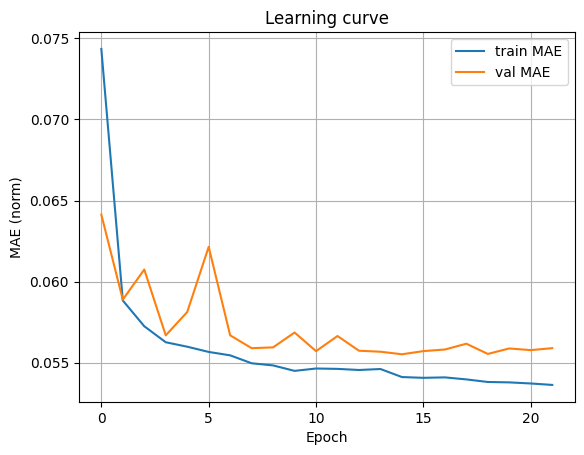

In [ ]:
#Training curves
import matplotlib.pyplot as plt
plt.figure()
plt.plot(history.history['loss'],     label='train MAE')
plt.plot(history.history['val_loss'], label='val MAE')
plt.title('Learning curve')
plt.xlabel('Epoch'); plt.ylabel('MAE (norm)')
plt.legend(); plt.grid(True); plt.show()

182/182 ━━━━━━━━━━━━━━━━━━━━ 2s 7ms/step


<ipython-input-12-251091e050a3>:5: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  idx   = pd.date_range(start=test.index[SEQ_LEN], periods=len(true), freq='H')


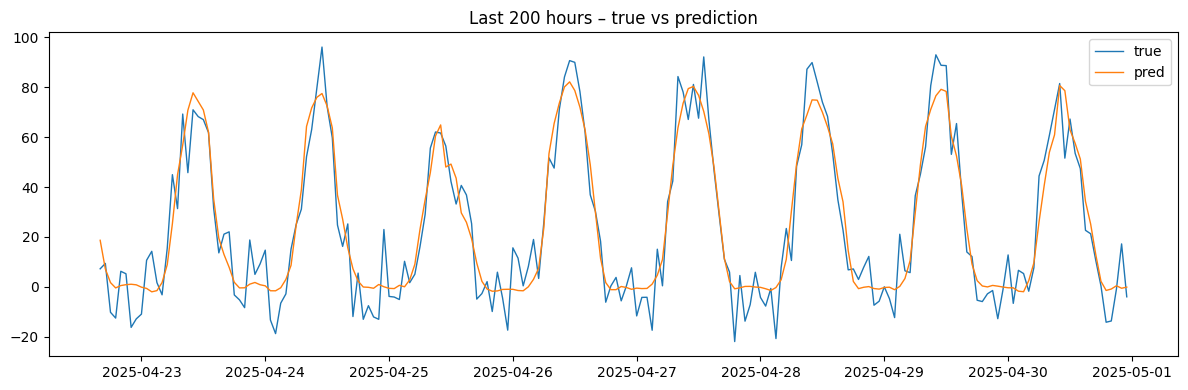

In [ ]:
#Prediction vs ground‑truth on test set
import numpy as np, matplotlib.pyplot as plt, pandas as pd
pred  = target_scaler.inverse_transform(model.predict(Xte)).ravel()
true  = target_scaler.inverse_transform(yte).ravel()
idx   = pd.date_range(start=test.index[SEQ_LEN], periods=len(true), freq='H')
plt.figure(figsize=(12,4))
plt.plot(idx[-200:], true[-200:], label='true', linewidth=1)
plt.plot(idx[-200:], pred[-200:], label='pred', linewidth=1)
plt.title('Last 200 hours – true vs prediction')
plt.legend(); plt.tight_layout(); plt.show()

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 356ms/step


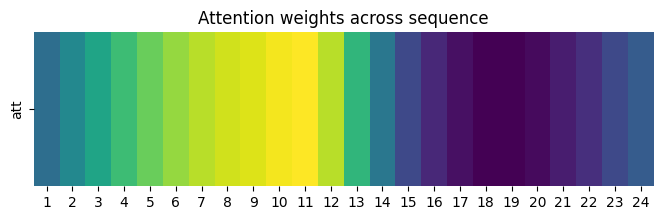

In [ ]:
#Attention heatmap for перший тест‑зразок
import numpy as np, matplotlib.pyplot as plt, seaborn as sns
from keras import Model
#пошук multiply‑layer (attention output)
target_layer = None
for layer in model.layers:
    if layer.name.startswith('multiply'):
        target_layer = layer
        break
if target_layer is None:
    print('⚠️  Attention layer not found')
else:
    att_model = Model(inputs=model.input, outputs=target_layer.output)
    att_weights = att_model.predict(Xte[:1])[0]  # shape (SEQ_LEN, features)
    weights = att_weights.sum(axis=-1)
    weights /= weights.max()
    plt.figure(figsize=(8,2))
    sns.heatmap(weights[np.newaxis,:], cmap='viridis', cbar=False,
                xticklabels=range(1, len(weights)+1), yticklabels=['att'])
    plt.title('Attention weights across sequence'); plt.show()

In [ ]:
#Reload artefacts (run at session start if needed)
import joblib, keras, os, numpy as np
drive_path = '/content/drive/MyDrive/pv'
model = keras.models.load_model(f'{drive_path}/model.keras')
feat_scaler   = joblib.load(f'{drive_path}/feat_scaler.gz')
target_scaler = joblib.load(f'{drive_path}/target_scaler.gz')
print('✅ Artefacts reloaded, ready for inference')

✅ Artefacts reloaded, ready for inference


In [ ]:
#Evaluate vs naïve‑lag1
pred  = target_scaler.inverse_transform(model.predict(Xte))
true  = target_scaler.inverse_transform(yte)
mape  = np.mean(np.abs((true - pred) / true)) * 100
naive = np.mean(np.abs((true[1:] - true[:-1]) / true[1:])) * 100
print(f'📉  MAPE LSTM = {mape:.2f}%  |  Naive = {naive:.2f}%')

182/182 ━━━━━━━━━━━━━━━━━━━━ 2s 8ms/step
📉  MAPE LSTM = 163.91%  |  Naive = 467.91%


In [ ]:
def forecast48(lat=LAT, lon=LON):
    url = (f"https://api.open-meteo.com/v1/forecast?"
           f"latitude={lat}&longitude={lon}"
           f"&hourly={','.join(HOURLY_VARS)}&forecast_days=2&timezone=UTC")

    df = pd.DataFrame(requests.get(url, timeout=30).json()['hourly'])
    df['datetime'] = pd.to_datetime(df.pop('time'))


    df = df.rename(columns={
        'temperature_2m':      'temp',
        'cloudcover':          'clouds',
        'windspeed_10m':       'wind_speed',
        'shortwave_radiation': 'radiation'
    })

    # далі — ті самі дії
    feats = feat_scaler.transform(df[FEATS])          # FEATS = ['temp','clouds','wind_speed','radiation']
    seqs  = np.stack([feats[i-SEQ_LEN:i] for i in range(SEQ_LEN, len(df))])
    pv_hat = target_scaler.inverse_transform(model.predict(seqs)).ravel()

    return df.iloc[SEQ_LEN:].assign(pv_kw_pred=pv_hat)

forecast48().head()


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step


,temp,clouds,wind_speed,radiation,datetime,pv_kw_pred
24,9.8,100,11.5,0.0,2025-05-06 00:00:00,-21.351124
25,8.9,100,13.0,0.0,2025-05-06 01:00:00,-21.549982
26,8.1,100,11.5,0.0,2025-05-06 02:00:00,-21.085464
27,7.3,100,10.8,0.0,2025-05-06 03:00:00,-21.076220
28,7.0,100,10.1,3.0,2025-05-06 04:00:00,-20.698143


In [ ]:
from flask import Flask, request, jsonify
from pyngrok import ngrok, conf
import os, numpy as np


try:
    from google.colab import userdata   # noqa: F401
    NGROK_TOKEN = userdata.get('NGROK_TOKEN')
except (ImportError, Exception):
    NGROK_TOKEN = None                  # secrets недоступні / не створені


NGROK_TOKEN = NGROK_TOKEN or os.getenv('NGROK_TOKEN')


NGROK_TOKEN = NGROK_TOKEN or "2wcrRMlSH9Ml5Xv2ifRwSkCHTnX_6aBQkKAY9oQU4xtNPfu5K"

if not NGROK_TOKEN:
    raise RuntimeError("❌ NGROK_TOKEN is not заданий у Secrets, env або коді.")

conf.get_default().auth_token = NGROK_TOKEN

# ── Flask API
app = Flask(__name__)

@app.route('/v1/predict', methods=['POST'])
def predict():
    seq = np.array(request.json['seq'], dtype=float).reshape(1, SEQ_LEN, -1)
    seq = feat_scaler.transform(seq[0]).reshape(1, SEQ_LEN, -1)
    y   = model.predict(seq).ravel()[0]
    kw  = float(target_scaler.inverse_transform([[y]])[0, 0])
    return jsonify({'kw': kw})

public_url = ngrok.connect(5000, bind_tls=True).public_url
print(f"🌐  Prod URL → {public_url}/v1/predict")

app.run('0.0.0.0', 5000, debug=False, use_reloader=False)


🌐  Prod URL → https://bee5-34-80-85-64.ngrok-free.app/v1/predict
 * Serving Flask app '__main__'
 * Debug mode: off


INFO:werkzeug:WARNING: This is a development server. Do not use it in a production deployment. Use a production WSGI server instead.
 * Running on all addresses (0.0.0.0)
 * Running on http://127.0.0.1:5000
 * Running on http://172.28.0.12:5000
INFO:werkzeug:Press CTRL+C to quit
